In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
from sklearn.manifold import TSNE


In [ ]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X = X / 255.0  # Scale pixel values to range [0, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X.shape, y.shape

((70000, 784), (70000,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.143, random_state=42, stratify=y)


In [ ]:
X_train.shape

(59990, 784)

In [ ]:
# Define transform to normalize the data for PyTorch MLP
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to range [-1, 1]
])

In [ ]:

# Load MNIST dataset using torchvision for PyTorch MLP
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 120986943.37it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 109229660.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47673116.91it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5316921.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Create DataLoader for batches for PyTorch MLP
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)

In [ ]:


# Define MLP architecture for PyTorch
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)  # 30 neurons in the first layer
        self.fc2 = nn.Linear(30, 20)      # 20 neurons in the second layer
        self.fc3 = nn.Linear(20, 10)      # 10 neurons in the output layer

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# Initialize the MLP model, loss function, and optimizer for PyTorch
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 50
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 0.5882270886922187
Epoch 2, Loss: 0.3072186874698347
Epoch 3, Loss: 0.26503420892808993
Epoch 4, Loss: 0.23621238377302695
Epoch 5, Loss: 0.21420478389096032
Epoch 6, Loss: 0.20007665791729493
Epoch 7, Loss: 0.18759301616184748
Epoch 8, Loss: 0.17669462655255916
Epoch 9, Loss: 0.16828368429436105
Epoch 10, Loss: 0.16026589950062095
Epoch 11, Loss: 0.15284012541421124
Epoch 12, Loss: 0.14807211809448087
Epoch 13, Loss: 0.14484111022656915
Epoch 14, Loss: 0.14227361684001838
Epoch 15, Loss: 0.13828991624469092
Epoch 16, Loss: 0.13386156953680617
Epoch 17, Loss: 0.13226759984596834
Epoch 18, Loss: 0.13004266901183992
Epoch 19, Loss: 0.12595700582604547
Epoch 20, Loss: 0.12347951907712196
Epoch 21, Loss: 0.12326838267542152
Epoch 22, Loss: 0.11924422693861796
Epoch 23, Loss: 0.11922063093993869
Epoch 24, Loss: 0.11795020635936783
Epoch 25, Loss: 0.11604756940164164
Epoch 26, Loss: 0.11471836992066854
Epoch 27, Loss: 0.11323467299326269
Epoch 28, Loss: 0.11144645777898335
Epo

In [ ]:
activations_train = []
with torch.no_grad():
    for data in train_loader:
        inputs, _ = data
        outputs = model(inputs)
        activations_train.append(model.fc2(torch.relu(model.fc1(inputs.view(-1, 28*28)))).detach().numpy())

activations_train = np.concatenate(activations_train, axis=0)

# Extract activations from the untrained model



In [ ]:
untrained_model = MLP()
activations_untrained = []
with torch.no_grad():
    for data in train_loader:
        inputs, _ = data
        outputs = untrained_model(inputs)
        activations_untrained.append(untrained_model.fc2(torch.relu(untrained_model.fc1(inputs.view(-1, 28*28)))).detach().numpy())

activations_untrained = np.concatenate(activations_untrained, axis=0)

In [ ]:
# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_train = tsne.fit_transform(activations_train)
tsne_untrained = tsne.fit_transform(activations_untrained)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
y_train.shape, tsne_train.shape

((59990,), (60000, 2))

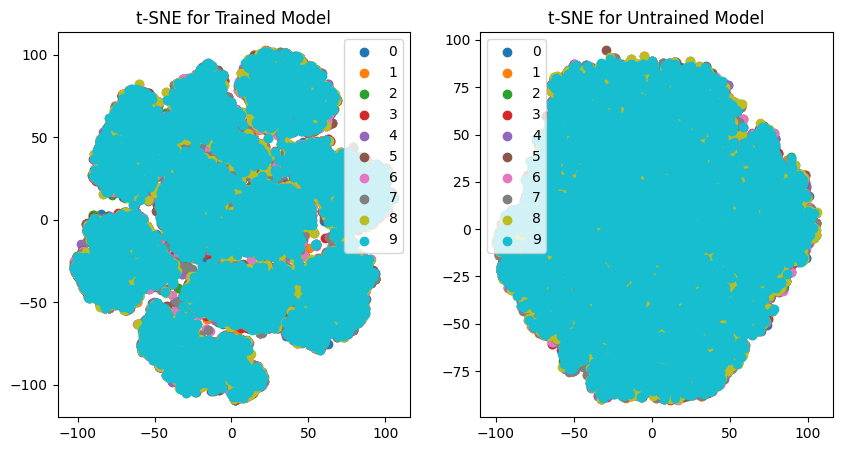

In [ ]:
tsne_train_truncated = tsne_train[:len(y_train)]
tsne_untrained_truncated = tsne_untrained[:len(y_train)]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('t-SNE for Trained Model')
for i in range(10):
    plt.scatter(tsne_train_truncated[y_train.astype(int) == i, 0], tsne_train_truncated[y_train.astype(int) == i, 1], label=str(i))
plt.legend()
plt.subplot(1, 2, 2)
plt.title('t-SNE for Untrained Model')
for i in range(10):
    plt.scatter(tsne_untrained_truncated[y_train.astype(int) == i, 0], tsne_untrained_truncated[y_train.astype(int) == i, 1], label=str(i))
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


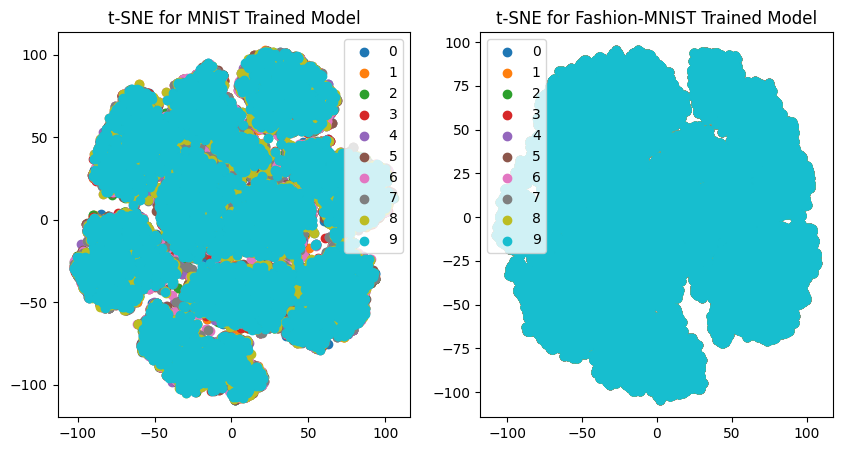

In [ ]:
import torchvision.datasets as datasets

# Load Fashion-MNIST dataset
fashion_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

fashion_train_loader = torch.utils.data.DataLoader(fashion_trainset, batch_size=64, shuffle=False)

# Predict on Fashion-MNIST using the trained MLP model
fashion_activations = []
with torch.no_grad():
    for data in fashion_train_loader:
        inputs, _ = data
        outputs = model(inputs)
        fashion_activations.append(model.fc2(torch.relu(model.fc1(inputs.view(-1, 28*28)))).detach().numpy())

fashion_activations = np.concatenate(fashion_activations, axis=0)

# Reduce dimensionality using t-SNE for Fashion-MNIST embeddings
tsne_fashion = TSNE(n_components=2, random_state=42)
tsne_fashion_train = tsne_fashion.fit_transform(fashion_activations)

# Plot t-SNE for both MNIST and Fashion-MNIST embeddings
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('t-SNE for MNIST Trained Model')
for i in range(10):
    plt.scatter(tsne_train_truncated[y_train.astype(int) == i, 0], tsne_train_truncated[y_train.astype(int) == i, 1], label=str(i))
plt.legend()

plt.subplot(1, 2, 2)
plt.title('t-SNE for Fashion-MNIST Trained Model')
for i in range(10):
    plt.scatter(tsne_fashion_train[:, 0], tsne_fashion_train[:, 1], label=str(i))
plt.legend()
plt.show()
